In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(4682)

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Kfold cv
from sklearn.model_selection import KFold

# Random forest
from sklearn.ensemble import RandomForestClassifier

# Lasso FS
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Importing xgboost and shap
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import fbeta_score

import seaborn as sns

# Loading datasets

In [2]:
import os
data_dir = './data/'
files = os.listdir(data_dir)
df_names = [file for file in files if file.endswith('.pkl')]
dfs = {}
for name in df_names:
    dfs[name] = pd.read_pickle(data_dir + name)

# Experiment Parameters

In [3]:
# split data into train and test sets
seed = 7
test_size = 0.33

## Random Forest Parameter Grid

In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## Finding the best parameters for random forests

In [5]:
exp_data = {}
for name, df in dfs.items():
    X = StandardScaler().fit_transform(df.drop('outcome', axis=1))
    y = df['outcome'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=seed, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print(name + " Accuracy: %.2f%%" % (accuracy * 100.0))
    model = rf_random.best_estimator_
#     model.set_params(**rf_random.best_params_)
#     model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    exp_data[name] = {'model': model,
                     'best_params': rf_random.best_params_}

Fitting 3 folds for each of 100 candidates, totalling 300 fits
sonar.pkl Accuracy: 84.06%
Fitting 3 folds for each of 100 candidates, totalling 300 fits
heart.pkl Accuracy: 80.81%
Fitting 3 folds for each of 100 candidates, totalling 300 fits
breast_cancer.pkl Accuracy: 97.79%
Fitting 3 folds for each of 100 candidates, totalling 300 fits
ionosphere.pkl Accuracy: 95.69%


## Running all models

In [6]:
for name, df in dfs.items():
    print("Running experiments for {}".format(name))
    results = []

    features = df.columns[df.columns!='outcome']
    X = StandardScaler().fit_transform(df.drop('outcome', axis=1))
    y = df['outcome'].values
    
    cv = KFold(n_splits=2, random_state=seed, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        
        # LASSO
        sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='saga'))
        sel_.fit(X_train, y_train)
        lasso_df = pd.DataFrame(sel_.estimator_.coef_.ravel(), index=df[features].columns, columns=["LASSO"])
        lasso_df.sort_values(by="LASSO", inplace=True, ascending=False)
        
        # Random Forests
        model = RandomForestClassifier()
        model.set_params(**exp_data[name]['best_params'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  # make predictions for test data
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions) # evaluate predictions
        print(name + ": RF Accuracy: %.2f%%" % (accuracy * 100.0))

        # RF SHAP: explain the model's predictions using SHAP
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        mean_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
        shap_df = pd.DataFrame(mean_shap_values, index=df[features].columns, columns=["SHAP"])
        shap_df.sort_values(by="SHAP", inplace=True, ascending=False)
        
        # RF Feature Importance
        importances = model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model.estimators_],
                     axis=0)
        indices = np.argsort(importances)[::-1]
        fi_df = pd.DataFrame(dict(zip(features[indices], importances[indices])), index=['Importance'])
        fi_df = fi_df.T

        # Univariate (KBest) FS using F-Score
        test = SelectKBest(score_func=f_classif, k=X_train.shape[1])
        fit = test.fit(X_train, y_train)
        set_printoptions(precision=3)
        kbest_dict = dict(zip(df.drop('outcome', axis=1).columns, fit.scores_))
        kbest_df = pd.DataFrame(kbest_dict, index=['KBest']).transpose()
        kbest_df.sort_values(by='KBest', ascending=False, inplace=True)
        
        # LDA
        X_train_df = pd.DataFrame(X_train, columns=df.drop(["outcome"], axis=1).columns)  # Transforming X from numpy to pandas to recover features
        X_test_df = pd.DataFrame(X_test, columns=df.drop(["outcome"], axis=1).columns)
        lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
        lda.fit(X_train_df.values, y_train)
        y_pred = lda.predict(X_test_df)
        explainer = shap.KernelExplainer(lda.predict_proba, X_train_df) # use Kernel SHAP to explain test set predictions
        shap_values = explainer.shap_values(X_test, nsamples=100)
        lda_shap_df = pd.DataFrame(np.mean(np.abs(shap_values[0]), axis=0), index=X_train_df.columns, columns=["LDA_SHAP"])
        lda_shap_df.sort_values(by="LDA_SHAP", ascending=False, inplace=True)
        
        # Assembling results into the same dataset
        fs_df = pd.DataFrame(list(zip(shap_df.index, fi_df.index, kbest_df.index, lda_shap_df.index, lasso_df.index)), 
                             columns=["SHAP", "Importance", "KBest", "LDA_SHAP", "LASSO"])
        fs_df.head()
        LDA_scores = pd.DataFrame(index=range(fs_df.shape[0]), columns=fs_df.columns)  # Initializing dataframe for results
        
        # Training LDA models for each number of features, for each model
        for num_features in range(fs_df.shape[0]):
            fs_df.iloc[:num_features+1]
            for method in fs_df.columns:
                selected_features = fs_df.iloc[:num_features+1][method]
                lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
                y_pred = lda.fit(X_train_df[selected_features].values, y_train).predict(X_test_df[selected_features])
                LDA_scores.loc[num_features, method] = fbeta_score(y_test, y_pred, beta=1)
        results.append(LDA_scores)
    
    # Gathering results from different dataframes
    exp_data[name]['results'] = results

Running experiments for sonar.pkl


The max_iter was reached which means the coef_ did not converge


sonar.pkl: RF Accuracy: 84.62%


Using 104 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/104 [00:00<?, ?it/s]

The max_iter was reached which means the coef_ did not converge


sonar.pkl: RF Accuracy: 84.62%


Using 104 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/104 [00:00<?, ?it/s]

Running experiments for heart.pkl


Using 148 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


heart.pkl: RF Accuracy: 83.89%


  0%|          | 0/149 [00:00<?, ?it/s]

Using 149 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


heart.pkl: RF Accuracy: 81.08%


  0%|          | 0/148 [00:00<?, ?it/s]

Running experiments for breast_cancer.pkl


The max_iter was reached which means the coef_ did not converge


breast_cancer.pkl: RF Accuracy: 97.95%


Using 341 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/342 [00:00<?, ?it/s]

The max_iter was reached which means the coef_ did not converge


breast_cancer.pkl: RF Accuracy: 96.77%


Using 342 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/341 [00:00<?, ?it/s]

Running experiments for ionosphere.pkl
ionosphere.pkl: RF Accuracy: 93.18%


The max_iter was reached which means the coef_ did not converge
Features [1] are constant.
invalid value encountered in true_divide
Using 175 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/176 [00:00<?, ?it/s]

The max_iter was reached which means the coef_ did not converge
Features [1] are constant.
invalid value encountered in true_divide
Using 176 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


ionosphere.pkl: RF Accuracy: 91.43%


  0%|          | 0/175 [00:00<?, ?it/s]

In [11]:
dfs.keys()

dict_keys(['sonar.pkl', 'heart.pkl', 'breast_cancer.pkl', 'ionosphere.pkl'])

In [12]:
name_dict = {
    'breast_cancer.pkl': 'Breast Cancer Winconsin',
    'heart.pkl': 'Heart Disease',
    'sonar.pkl': 'SONAR',
    'ionosphere.pkl': 'Ionosphere',
}

def plot_results(exp_data, df_name, methods=["SHAP", "Importance", "KBest", "LDA_SHAP", "LASSO"]):
    results = exp_data[df_name]['results']
    dims = (15, 8)
    fig, ax = plt.subplots(figsize=dims)

    columns = results[0].columns
    CV_LDA_scores = pd.DataFrame(columns=["FScore", "NFeatures", "Method", "Fold"])

    for fold, lda_result in enumerate(results):
        for col in columns:
            test_df = pd.DataFrame({"FScore" : lda_result[col],
                                    "NFeatures": np.arange(len(lda_result))+1,
                                    "Method": [col]*len(lda_result),
                                    "Fold": [fold]*len(lda_result)})
            CV_LDA_scores = pd.concat([CV_LDA_scores, test_df])

    # Asserting data types
    CV_LDA_scores.FScore = CV_LDA_scores.FScore.astype(float)
    CV_LDA_scores.NFeatures = CV_LDA_scores.NFeatures.astype(int)
    # Plot
    sns.lineplot(ax=ax, data=CV_LDA_scores[CV_LDA_scores['Method'].isin(methods)], x="NFeatures", y="FScore", hue="Method", ).set_title(name_dict[df_name] + ' Database')

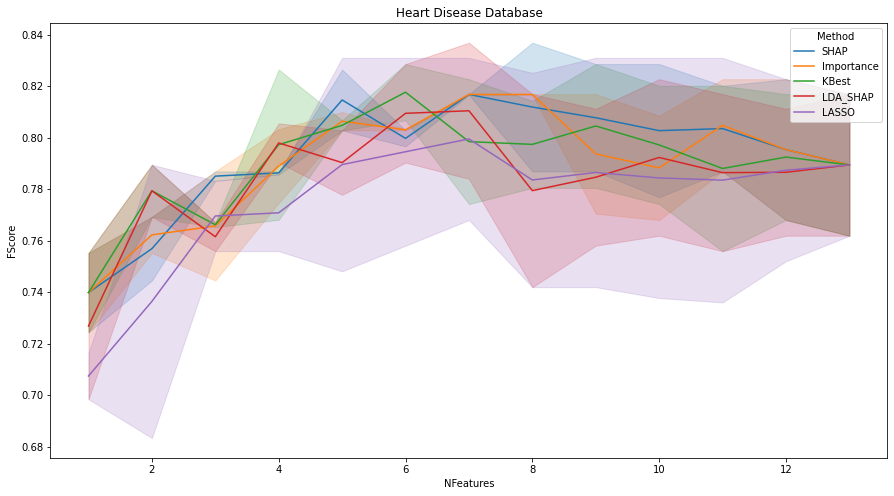

In [13]:
plot_results(exp_data, 'heart.pkl')

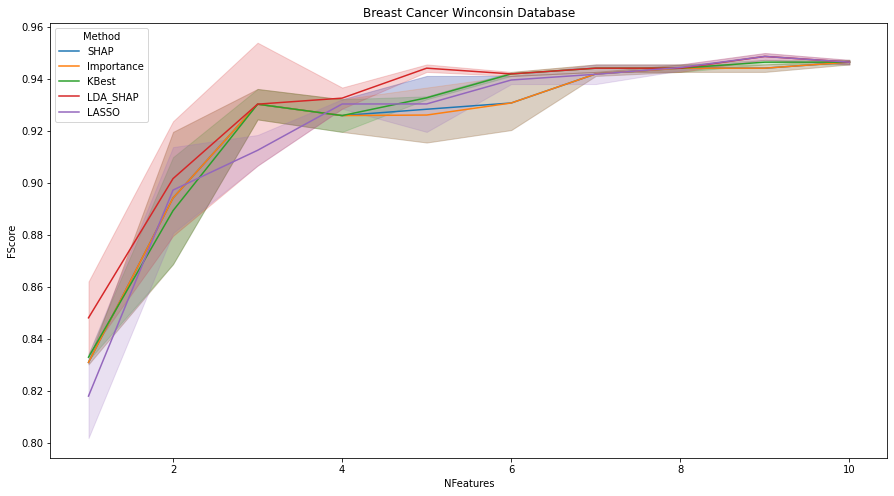

In [14]:
plot_results(exp_data, 'breast_cancer.pkl')

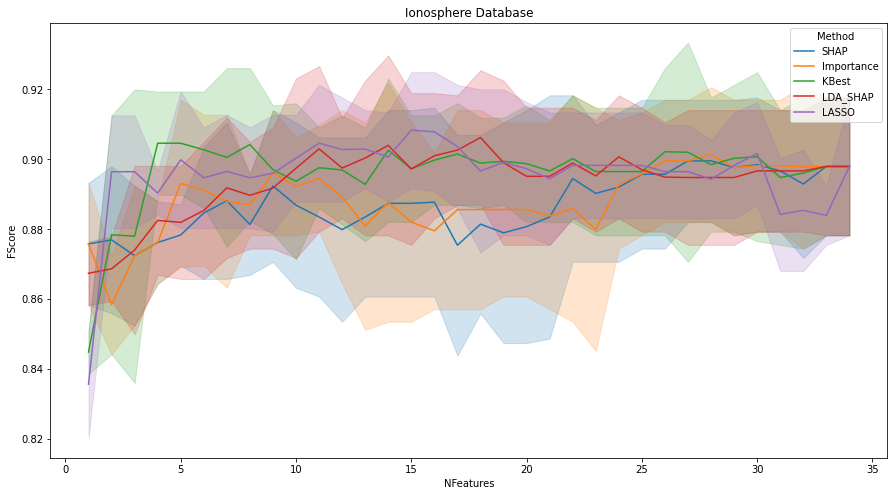

In [15]:
plot_results(exp_data, 'ionosphere.pkl')

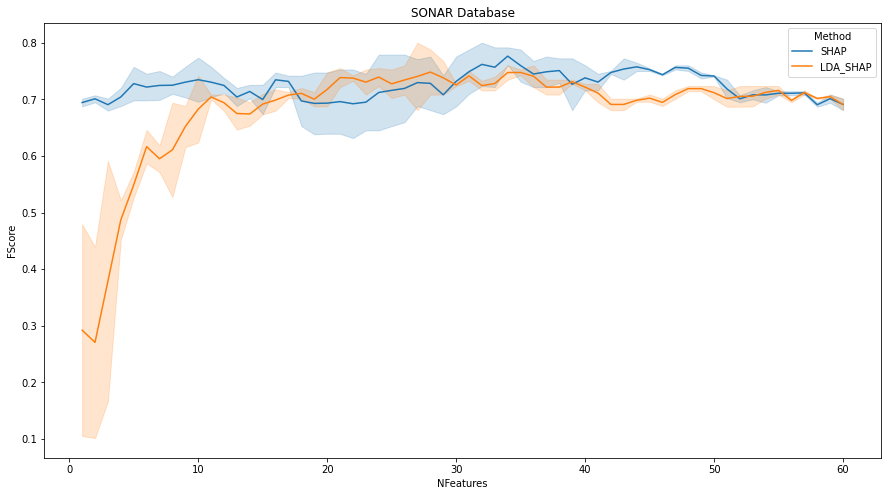

In [17]:
plot_results(exp_data, 'sonar.pkl', methods=['LDA_SHAP', 'SHAP'])

Text(0.5, 1.0, 'Breast Cancer Winconsin Database')

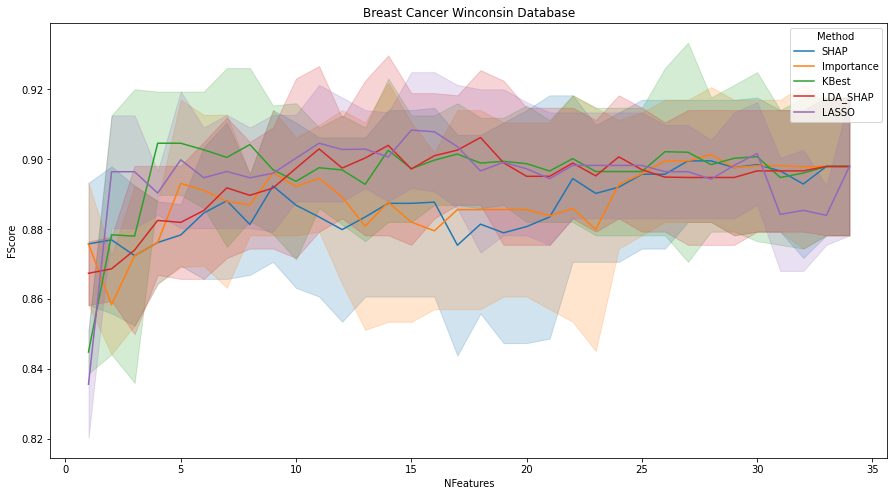

In [9]:
dims = (15, 8)
fig, ax = plt.subplots(figsize=dims)

columns = results[0].columns
CV_LDA_scores = pd.DataFrame(columns=["FScore", "NFeatures", "Method", "Fold"])

for fold, lda_result in enumerate(results):
    for col in columns:
        test_df = pd.DataFrame({"FScore" : lda_result[col],
                                "NFeatures": np.arange(len(lda_result))+1,
                                "Method": [col]*len(lda_result),
                                "Fold": [fold]*len(lda_result)})
        CV_LDA_scores = pd.concat([CV_LDA_scores, test_df])
        
# Asserting data types
CV_LDA_scores.FScore = CV_LDA_scores.FScore.astype(float)
CV_LDA_scores.NFeatures = CV_LDA_scores.NFeatures.astype(int)
# Plot
sns.lineplot(ax=ax, data=CV_LDA_scores, x="NFeatures", y="FScore", hue="Method", ).set_title('Breast Cancer Winconsin Database')

Text(0.5, 1.0, 'Heart Disease Database')

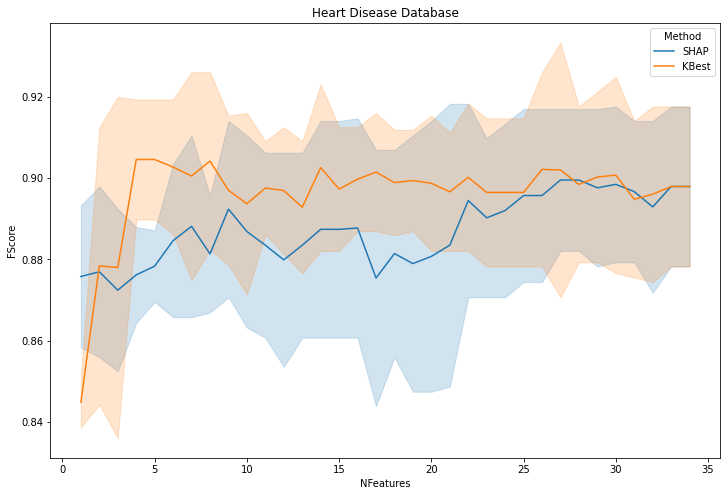

In [10]:
# Plot
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data=CV_LDA_scores[CV_LDA_scores['Method'].isin(['KBest', 'SHAP'])], x="NFeatures", y="FScore", hue="Method").set_title('Heart Disease Database')